In [64]:
import pandas as pd
import json
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OrdinalEncoder
import numpy as np


In [65]:
meta = pd.read_csv('../data/FFMetadata_v10.csv',low_memory=False)
df = pd.read_csv('../data/FFChallenge_v5/background.csv',low_memory=False,index_col=0,na_values=[-9,-8,-6,-5,-4,-3,-2,-1])
constant = pd.read_csv('../data/FFChallenge_v5/constantVariables.txt',header=None,index_col=0)

print(f'Background: {df.shape[1]} variables')

print(f'Meta: {meta.shape[0]} variables')

print(f'Constant: {constant.shape[0]} variables')

Background: 13026 variables
Meta: 25684 variables
Constant: 2432 variables


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4242 entries, 1 to 4242
Columns: 13026 entries, cf1intmon to k5f1
dtypes: float64(12880), int64(30), object(116)
memory usage: 421.6+ MB


In [67]:
df.columns[df.columns.isin(meta.new_name)]

Index(['cf1intmon', 'cf1intyr', 'cf1lenhr', 'cf1lenmin', 'cf1twoc', 'cf1fint',
       'cf1natsm', 'f1natwt', 'cf1natsmx', 'f1natwtx',
       ...
       'q5citywt_rep63', 'q5citywt_rep64', 'q5citywt_rep65', 'q5citywt_rep66',
       'q5citywt_rep67', 'q5citywt_rep68', 'q5citywt_rep69', 'q5citywt_rep70',
       'q5citywt_rep71', 'q5citywt_rep72'],
      dtype='object', length=12840)

# Drop constantVariables.txt

In [68]:
df.drop(constant.index.values,axis=1,inplace=True)
delcols = df.std()[df.std() == 0].index
df.drop(delcols,axis=1,inplace=True)

print(f'Background without constant: {df.shape[1]} variables')

/tmp/ipykernel_43971/1791826707.py:2: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  delcols = df.std()[df.std() == 0].index


Background without constant: 10211 variables


/tmp/ipykernel_43971/1791826707.py:2: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  delcols = df.std()[df.std() == 0].index


In [69]:
df.T.duplicated(keep='first')

cf1lenhr     False
cf1lenmin    False
cf1fint      False
cf1citsm     False
f1citywt     False
             ...  
m5c6         False
m5d20        False
m5k10        False
f5c6         False
k5f1         False
Length: 10211, dtype: bool

In [70]:
df.T.duplicated(keep='first').value_counts()

False    10069
True       142
dtype: int64

In [71]:
# Drop one copy of identical variables

df = df.loc[:,~df.T.duplicated(keep='first')]

print(f'Background without constant and duplicates: {df.shape[1]} variables')

Background without constant and duplicates: 10069 variables


# Drop columns with excessive real missing values

In [72]:
def dropvars(df,nan_threshold=0.7):
    # thresh = Require that many non-NA values 
    return df.dropna(thresh=len(df)*nan_threshold, axis=1)

df = dropvars(df)

df

,cf1lenmin,cf1fint,cf1citsm,f1citywt,f1a2,f1a3,f1a4,f1a5,f1a6,f1b1a,...,m4d9,m4e23,f4d6,f4d7,f4d9,m5c6,m5d20,m5k10,f5c6,k5f1
challengeID,,,,,,,,,,,,,,,,,,,,,
1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.27,5.18,2.51,1.72,6.47,16.37,4.48,9.63,15.98,24.04
2,40.00,1,1.00,68.46,2.00,1.00,1.00,1.00,1.00,1.00,...,6.27,27.68,2.51,1.72,6.47,16.37,26.67,9.63,15.98,3.67
3,45.00,1,1.00,42.32,1.00,1.00,1.00,1.00,2.00,3.00,...,6.27,5.18,20.87,24.12,6.47,16.37,4.48,9.63,15.98,24.04
4,45.00,1,1.00,25.63,1.00,1.00,1.00,1.00,2.00,3.00,...,6.27,5.18,22.02,22.93,6.47,-5.17,4.48,9.63,-6.30,4.14
5,50.00,1,1.00,41.95,2.00,1.00,1.00,1.00,2.00,4.00,...,6.27,5.18,22.92,22.99,6.47,-6.03,4.48,9.63,-6.21,3.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4238,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27.94,5.18,2.51,1.72,6.47,16.37,4.48,9.63,15.98,24.04
4239,40.00,1,1.00,64.20,2.00,1.00,1.00,1.00,2.00,0.00,...,28.70,5.18,2.51,1.72,6.47,16.37,4.48,9.63,15.98,3.42
4240,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.27,26.99,2.51,1.72,6.47,16.37,4.48,9.63,15.98,24.04


In [73]:
print(f'Background without excessive missing values: {df.shape[1]} variables')

Background without excessive missing values: 1593 variables


# Remove colinear variables

In [74]:
def remove_colinear(df,threshold):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(to_drop,axis=1)

df = remove_colinear(df,0.95)


/tmp/ipykernel_43971/2137515092.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr().abs()
/tmp/ipykernel_43971/2137515092.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


# Select survey and constructed variables

In [ ]:
# dtypes[dtypes.new_name == 'cf4fint']
# string = '1960-01-02'
# mask = df.isin(['1960-01-01']).any()
# df.columns[mask]

In [75]:
cols = [col for col in df.columns if col in meta.new_name.values]

malformed = {
    'r3b26_a': 'Has text instead of numerical encodings',
    'cf4fint': 'cf4fint encoded as binary but has 1960-01-01',
    'm5f23a': 'Used in target variable',
    'n5g1e': 'Used in target variable',
    'n5g1j': 'Used in target variable',
    'm5f23e': 'Used in target variable',
    'm5f23k': 'Used in target variable',
    'm5f23c': 'Used in target variable',
    'f5f23c': 'Used in target variable',
}

for key in malformed.keys():
    if key in cols:
        cols.remove(key)
        print(f'Removed {key} from cols')

# get only questionnaire and constructed variables

meta = meta[meta.new_name.isin(cols)][meta.source.isin(['questionnaire','constructed'])]

cols = meta[meta.topics != 'Paradata and weights'].new_name

df = df[cols]

print(f'Background without malformed variables: {df.shape[1]} variables')

Removed cf4fint from cols
Removed m5f23a from cols
Removed m5f23e from cols
Removed m5f23k from cols
Removed m5f23c from cols
Background without malformed variables: 1204 variables


/tmp/ipykernel_43971/596351072.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meta = meta[meta.new_name.isin(cols)][meta.source.isin(['questionnaire','constructed'])]


# Drop cols with low-variance

In [76]:
pd.options.display.float_format = '{:.2f}'.format

df.var().describe()

count         1204.00
mean       6119034.68
std       76510058.40
min              0.00
25%              0.11
50%              0.25
75%              1.04
max     1228819128.68
dtype: float64

<Axes: >

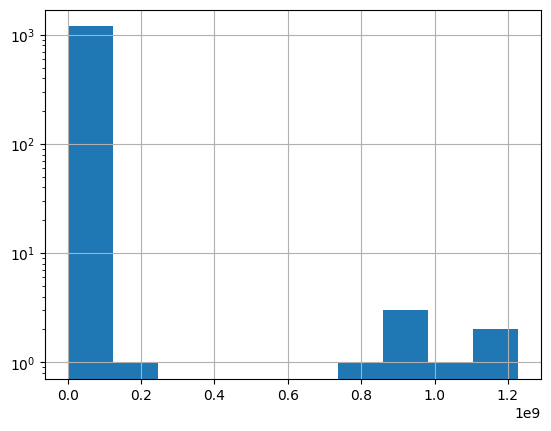

In [77]:
df.var().hist(bins=10,log=True)

In [78]:
sel = VarianceThreshold(threshold=0.01)

ordinal_encoder = OrdinalEncoder()
ordinaldf = ordinal_encoder.fit_transform(df)
sel.fit(ordinaldf)

df = df[df.columns[sel.get_support(indices=True)]]
print(f'Background without low variance: {df.shape[1]} variables')

Background without low variance: 1185 variables


In [79]:
pd.options.display.float_format = '{:.2f}'.format

df.var().describe()

count         1185.00
mean       6217145.77
std       77117546.93
min              0.01
25%              0.12
50%              0.25
75%              1.05
max     1228819128.68
dtype: float64

# Remove by type of variable

In [80]:
meta.source.value_counts()

questionnaire    1082
constructed       162
Name: source, dtype: int64

In [81]:
meta[meta.new_name.isin(cols)].source.value_counts()

questionnaire    1077
constructed       127
Name: source, dtype: int64

## Check datatypes and topics

In [82]:
meta[meta.new_name.isin(cols)].type.value_counts()

Binary                   570
Ordered Categorical      414
Unordered Categorical    114
Continuous               106
Name: type, dtype: int64

In [83]:
meta[meta.new_name.isin(cols)].topics.value_counts().head(15)

Health and health behavior                 159
Finances                                   119
Housing and neighborhood                   103
Attitudes and expectations                  87
Parenting                                   85
Romantic relationships                      78
Family and social ties                      75
Education and school                        66
Employment                                  63
Cognitive and behavioral development        63
Finances ; Housing and neighborhood         23
Legal system                                21
Housing and neighborhood ; Demographics     21
Parenting ; Romantic relationships          20
Health and health behavior ; Parenting      13
Name: topics, dtype: int64

# Export metadata

In [84]:
myvars = meta[meta.new_name.isin(cols)].copy()

myvars['one_topic'] = myvars['topics'].str.split(';').str[0]

# trim one topic
myvars['one_topic'] = myvars['one_topic'].str.strip()

# remove space and upper case
myvars['one_topic'] = myvars['one_topic'].str.replace(' ','_').str.lower()

dtypes = myvars[['new_name','varlab','type','one_topic']].copy()

dtypes

,new_name,varlab,type,one_topic
13,f1a2,Were you present at the birth?,Binary,parenting
14,f1a3,Have you held baby(ies)?,Binary,parenting
15,f1a4,Will the baby(ies) have your last name?,Binary,parenting
17,f1a5,Will your name be on the birth certificate?,Binary,parenting
19,f1a6,Do you have other biological children?,Binary,health_and_health_behavior
...,...,...,...,...
12779,cm5edu,Constructed - Mother's education: year 9,Ordered Categorical,education_and_school
12781,cm5hhinc,Constructed - Mother's Household income (with ...,Continuous,finances
12783,cm5hhimp,Flag var for household income imputation - mot...,Unordered Categorical,finances
12787,cm5povco,Constructed - Mother's household income/povert...,Continuous,finances


In [85]:
ordcat_list = dtypes[dtypes.type == 'Ordered Categorical']

dictdtype = {
    'Binary': 'float64', 
    # 'Ordered Categorical': CategoricalDtype(categories=ordcat_list, ordered=True),
    'Ordered Categorical': 'float64',
    'Continuous': 'float64',
    'Unordered Categorical': 'category',
}

dtypes['dtype'] = dtypes.type.map(dictdtype)

# Remove strings and export metadata.json

In [86]:
dtypes = dtypes[~dtypes.dtype.isna()] # remove strings

dtypes_dict = dict(zip(dtypes.new_name,dtypes.dtype))
dtypes_dict = {'challengeID': 'Int64', **dtypes_dict}

# dtypes_dict = {k: str(v) if isinstance(v, CategoricalDtype) else v for k, v in dtypes_dict.items()}

with open('../metadata/metadata.json', 'w') as fp:
    json.dump(dtypes_dict, fp)

In [87]:
# test
pd.read_csv('../data/FFChallenge_v5/background.csv',low_memory=False, \
                            dtype=dtypes_dict,\
                            usecols=dtypes_dict.keys()).set_index('challengeID')

,f1a2,f1a3,f1a4,f1a5,f1a6,f1b1a,f1b2,f1b26,f1b27,f1b28,...,cm5b_age,cm5md_case_con,cm5md_case_lib,cm5finjail,cm5fevjail,cm5edu,cm5hhinc,cm5hhimp,cm5povco,cm5povca
challengeID,,,,,,,,,,,,,,,,,,,,,
1,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,...,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9,-9.00,-9.00
2,2.00,1.00,1.00,1.00,1.00,1.00,2.00,1.00,2.00,2.00,...,117.00,0.00,0.00,0.00,0.00,1.00,4337.16,4,0.84,1.00
3,1.00,1.00,1.00,1.00,2.00,3.00,1.00,1.00,2.00,2.00,...,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9,-9.00,-9.00
4,1.00,1.00,1.00,1.00,2.00,3.00,2.00,1.00,2.00,2.00,...,108.00,0.00,0.00,0.00,0.00,4.00,62960.56,1,2.76,4.00
5,2.00,1.00,1.00,1.00,2.00,4.00,2.00,1.00,2.00,2.00,...,113.00,0.00,0.00,0.00,0.00,2.00,11631.77,1,0.74,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4238,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,...,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9,-9.00,-9.00
4239,2.00,1.00,1.00,1.00,2.00,0.00,2.00,3.00,2.00,2.00,...,108.00,1.00,1.00,0.00,1.00,1.00,24696.79,4,0.98,2.00
4240,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,...,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9.00,-9,-9.00,-9.00


In [88]:
dtypes.to_csv('../metadata/variables.csv',index=False)